## Transmon system

We generalize the superconducting transmon system with an arbitrary number of qutrit in the computational basis $\mathcal{B}=\{\ket{0,\dots,0},\ket{0,\dots,1},\dots,\ket{2,\dots,2}\}$, $\mathrm{dim}(\mathcal{B})\equiv D_{\mathcal{H}}$ described by the Hamiltonian
$$\hat{H}_n = \sum^{N}_{j=1}\left[\Delta_j\hat{b}^\dagger_j\hat{b}_j+\frac{1}{2}\delta_j\hat{b}^\dagger_j\hat{b}_j(\hat{b}^\dagger_j\hat{b}_j-1)+\sum_{\langle i, j\rangle}J_{ij}(\hat{b}^\dagger_i\hat{b}_j+\hat{b}_i\hat{b}^\dagger_j)+u^{(j)}_n(\hat{b}^\dagger_j+\hat{b}_j)\right]=\hat{H}_d+\hat{H}^c_n\;,$$
with qubit-dependent indices and where the sum $\langle i,j\rangle$ is over nearest neighbors.

The parameters are first chosen to be index-independent and we consider the gate transfer of a CNOT in the qubit subspace $\mathcal{S}=\{\ket{0,\dots,0},\ket{0,\dots,1},\dots,\ket{1,\dots,1}\}$.

Both the cases of local ($u^{(j)}_n$) and global ($u^{(j)}_n\equiv u_n\,\forall j$) control are implemented. As an important sanity check of the implementation of the integration methods, both rules should produce the same unitary.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('science')
from mpl2latex import mpl2latex, latex_figsize
mpl2latex()
from matplotlib.lines import Line2D

import numpy as np
from numpy import array, ndarray
from numpy.linalg import norm
from scipy.sparse import dia_matrix, kron, identity
from scipy.sparse.linalg import expm
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
from itertools import product
from functools import reduce
from scipy.optimize import fmin_l_bfgs_b

In [2]:
colorr = '#FF2C00'
colorb = '#0C5DA5'
colorg = '#00B945'
msize = 5

### Initialization

In [3]:
# simulation parameters

# global dimension
dim = 2
# local dimension
d = 3
# Hilbert space dimension
D_H = d**dim
# subspace dimension for the gate transfer
subdim = 2**dim
# control qubit index
ctrl_qubit_idx = 0
# target qubit index
tgt_qubit_idx = 1

In [4]:
twopi = 2 * np.pi

# transmon calibration parameters from IBM cloud
omegas = np.array([4.918, 5.003, 4.866, 5.104, 4.902, 5.04, 4.973, 5.033, 4.767, 4.87, 4.999, 5.077, 5.198, 4.994, 5.083])[:dim] * twopi
deltas = np.array([-0.3091, -0.30763, -0.31125, -0.30768, -0.30965, -0.30739, -0.30076, -0.30851, -0.30398, -0.31089, -0.30886, -0.30693, -0.30578, -0.30757, -0.30708])[:dim] * twopi

# Hamiltonian parameters as in https://arxiv.org/pdf/2006.00935.pdf
omega_r = 7.5 * twopi
g_1 = 0.1 * twopi
Deltas = omegas - omega_r
omegas_tilde = omegas + (g_1**2 / Deltas)
Js = array([(g_1**2 * (Deltas[n] + Deltas[n+1])) / (Deltas[n] * Deltas[n+1]) for n in range(dim-1)])
Deltas = array([omegas_tilde[n+1] - omegas_tilde[n] for n in range(dim-1)])

In [5]:
# scaling constants
e_unit = np.abs(max(Js))
t_unit = 1 / e_unit

# re-scale Hamiltonian constants
Deltas /= e_unit
deltas /= e_unit
Js /= e_unit

# target qubit has zero detuning
Deltas = np.insert(Deltas, tgt_qubit_idx, 0)

In [6]:
def input_parameters(T: float, dt: float):
    '''
    Defines input parameters for the simulation
 
    Parameters
    ----------
    T : float
        time window in SI-units (ns)
    dt : float
        time interval in non-dimensionalized numerical units

    Returns
    -------
    N : int
        nr of elements in the wave functions
    delta_t : float
        time interval in non-dimensionalized numerical units

    Prints
    ------
        effective time window containing an integer number of dt
    Nt : int
        nr of time steps & nr of time-evolving unitary operators

    Controls are N (Nt) for the trapezoidal (rectangular) rule
    '''
    T = T / t_unit
    Nt = T / dt
    res = Nt % 1
    Nt = int(Nt)
    N = Nt + 1

    print('eff time window:\t', np.round(T - res * dt,2))
    print('nr time steps:\t\t', Nt)

    return N, dt

In [7]:
N, delta_t = input_parameters(T=60, dt=0.015)

N_trap = N
N_rect = N - 1

eff time window:	 2.96
nr time steps:		 197


In [8]:
def initialize_controls(n_iter: int, loc_ctrl: bool) -> ndarray:
    '''
    Initializes vector of controls

    Parameters
    ----------
    n_iter : int
        number of time steps (length of the control vector)
    loc_ctrl : bool
        sets for local/global controls
    
    Returns
    -------
    u : array
        register of dimensions [nr of time steps × nr of controls]

    Row-major ordering: first index is the one of the nr of time steps, allowing for faster access
    '''
    u_thr = 0.2 * twopi / e_unit # 200 MHz
    if loc_ctrl:
        n_ctrl = dim
    else:
        n_ctrl = 1
    u = np.random.uniform(-u_thr, u_thr, size=(n_iter, n_ctrl))
    return u

In [9]:
# filters out values 100 * machine precision
eps = np.finfo(float).eps
filter_eps = lambda x: np.where(np.abs(x) > 100 * eps, x, 0.)

### Operators and Hamiltonian definition

In [10]:
def annihilation_sparse(dimension: int) -> csr_matrix:
    '''
    Returns the annihilation operator in sparse matrix form
    '''
    offdiag_elements = np.sqrt(range(dimension))
    return dia_matrix((offdiag_elements, [1]), shape=(dimension, dimension)).tocsr()

def creation_sparse(dimension: int) -> csr_matrix:
    '''
    Returns the creation operator in sparse matrix form
    '''
    return annihilation_sparse(dimension).transpose().tocsr()

In [11]:
# define creation and annihilation operators
b = annihilation_sparse(d)
bdg = creation_sparse(d)
bdgb = bdg @ b

In [12]:
# wrapper to store the matrices in the correct format
Id = lambda x: identity(x, format='csr')
Kron = lambda x,y: kron(x, y, format='csr')

In [13]:
def op_train(idxs: list, args: list) -> csr_matrix:
    '''
    Computes the many-body operator via tensor product
    
    Parameters
    ----------
    idxs : list
        list of single-site indices
    args : list
        list of single-site operators
    
    Returns
    -------
    op : csr_matrix
        resulting many-body operator
    '''
    train = np.repeat(Id(d), dim)
    for idx, arg in zip(idxs, args):
        train[idx] = arg
    op = reduce(Kron, train)
    return op

In [14]:
# compute eigenvalue/vectors in dense representation, controls are on all qubits
Hc = np.sum([op_train([n], [b + bdg]) for n in range(dim)]).toarray()
e, R = eigh(Hc)
# filter values
e, R = filter_eps(e), filter_eps(R)

# convert back to sparse representation, build rotation function
R = csr_matrix(R)
rotate = lambda x: R.T @ x @ R

# save only diagonal elements
Hc = e

In [15]:
# drift Hamiltonian before rotation
drift1 = np.sum([Deltas[n] * op_train([n], [bdgb]) for n in range(dim)])
drift2 = np.sum([1/2 * deltas[n] * op_train([n], [bdgb @ (bdgb - Id(d))]) for n in range(dim)])
drift3 = np.sum([Js[n] * (op_train([n, n+1], [bdg, b]) + op_train([n, n+1], [b, bdg])) for n in range(dim-1)])

Hd = (drift1 + drift2 + drift3)
print('degree of sparsity of Hd before rotation: {:%}'.format(Hd.nnz / np.product(Hd.shape)))

degree of sparsity of Hd before rotation: 18.518519%


In [16]:
# drift Hamiltonian after rotation
drift1 = np.sum([Deltas[n] * rotate(op_train([n], [bdgb])) for n in range(dim)])
drift2 = np.sum([1/2 * deltas[n] * rotate(op_train([n], [bdgb @ (bdgb - Id(d))])) for n in range(dim)])
drift3 = np.sum([Js[n] * (rotate(op_train([n, n+1], [bdg, b]) + op_train([n, n+1], [b, bdg]))) for n in range(dim-1)])

Hd = (drift1 + drift2 + drift3)
print('degree of sparsity of Hd after rotation: {:%}'.format(Hd.multiply(np.abs(Hd) > 100 * eps).nnz / np.product(Hd.shape)))

degree of sparsity of Hd after rotation: 90.123457%


### Integration rules, time evolution and gradient

In [17]:
# exponential of drift Hamiltonian is computed once: sparse is here not convenient
Hd = Hd.toarray()
expHd = expm(-1j * Hd * delta_t)
expHdconj = np.conj(expHd.T)

In [18]:
def state_train(rep: list) -> ndarray:
    '''
    Computes (rotated) sub-space basis states in arbitrary dimension
    
    Parameters
    ----------
    rep : list
        list of the combination of states
    
    Returns
    -------
    states : array
        resulting sub-space basis states
    '''
    kets = array([array([1,0,0]), array([0,1,0])])
    state_list = array([kets[n] for n in rep])
    state = (R.T.toarray() @ reduce(np.kron, state_list))
    return state

In [19]:
# create all possible combinations of states
reps = list(product([0,1], repeat=dim))

# initialize and construct initial and target states
ini_states = np.zeros((subdim, D_H), dtype=complex)
tgt_states = np.zeros((subdim, D_H), dtype=complex)

for idx, rep in enumerate(reps):
    rep = list(rep)
    ini_states[idx] = state_train(rep)
    # flip target qubit if CNOT
    if rep[ctrl_qubit_idx] == 1:
        rep[tgt_qubit_idx] = (rep[tgt_qubit_idx] + 1) % 2
    tgt_states[idx] = state_train(rep)

In [20]:
class trapezoid:

    def __init__(self, ctrl):
        self.ctrl = ctrl                                                                # controls
        self.N = self.ctrl.shape[0]                                                     # nr of evolutions = nr controls = Nt + 1 = N
        self.D_H = D_H                                                                  # local dimension
        self.subdim = subdim                                                            # sub-dimension of qubit subspace
        self.delta_t = delta_t                                                          # time step
        self.evolved_psi, self.evolved_chi = self.time_evolution()                      # evoluted wave functions
        self.overlap, self.coverlap = self.transfer_amplitude()                         # overlap, conjugated overlap
        
    def time_evolution(self):

        evolved_psi = np.zeros((self.N, self.subdim, self.D_H), dtype=complex)          # psi evolution vector
        evolved_chi = np.zeros((self.N, self.subdim, self.D_H), dtype=complex)          # chi evolution vector
        trotter = np.zeros((self.N-1, 2, self.D_H), dtype=complex)                      # trotterized operators

        evolved_psi[0]  = ini_states                                                    # initialize evolutions
        evolved_chi[-1] = tgt_states

        for n in range(1, self.N):                                                      # iterate over the control vector
            Hc_next = np.sum(self.ctrl[n]) * Hc
            Hc_curr = np.sum(self.ctrl[n-1]) * Hc

            a = np.exp(-1j * Hc_next * self.delta_t / 2)
            c = np.exp(-1j * Hc_curr * self.delta_t / 2)
            
            trotter[n-1] = a, c                                                         # save operator
            evolve_psi = lambda x: a * (expHd @ (c * x))                                # build trotterized propagator
            evolved_psi[n] = array([evolve_psi(psi) for psi in evolved_psi[n-1]])       # evolve psi
            evolved_psi[n] = array([psi / norm(psi) for psi in evolved_psi[n]])         # impose normalization
            
        for n in range(self.N-1, 0, -1):
            a, c = np.conj(trotter[n-1])
            evolve_chi = lambda x: c * (expHdconj @ (a * x))                            # build trotterized propagator
            evolved_chi[n-1] = array([evolve_chi(chi) for chi in evolved_chi[n]])       # evolve chi
            evolved_chi[n-1] = array([chi / norm(chi) for chi in evolved_chi[n-1]])     # impose normalization
        
        return evolved_psi, evolved_chi

    def transfer_amplitude(self):
        over = array([np.dot(np.conj(chi), psi) for chi, psi in zip(self.evolved_chi[-1], self.evolved_psi[-1])])
        return over, np.conj(over)                                                      # transfer amplitude

    def F(self):
        return (np.abs(1/self.subdim * np.sum(self.overlap)))**2                        # fidelity

    def gradient(self):
        theta = np.conj(np.sum(self.overlap))
        g = np.zeros(self.N)
        for k in range(self.subdim):
            sandwich = array([np.conj(self.evolved_chi[n][k]) @ (Hc * self.evolved_psi[n][k]) for n in range(self.N)])
            sandwich[0]  *= 1/2
            sandwich[-1] *= 1/2
            g += np.real(1j * theta * sandwich)
        return g * (self.delta_t/self.subdim**2)                                        # gradient

In [21]:
class rectangle:

    def __init__(self, ctrl):
        self.ctrl = ctrl                                                                # controls
        self.N = self.ctrl.shape[0] + 1                                                 # nr of evolutions = nr of controls + 1 = Nt + 1 = N
        self.D_H = D_H                                                                  # local dimension
        self.subdim = subdim                                                            # sub-dimension of qubit subspace
        self.delta_t = delta_t                                                          # time step
        self.evolved_psi, self.evolved_chi = self.time_evolution()                      # evoluted wave functions
        self.overlap, self.coverlap = self.transfer_amplitude()                         # overlap, conjugated overlap
        
    def time_evolution(self):

        evolved_psi = np.zeros((self.N, self.subdim, self.D_H), dtype=complex)          # psi evolution vector
        evolved_chi = np.zeros((self.N, self.subdim, self.D_H), dtype=complex)          # chi evolution vector
        trotter = np.zeros((self.N-1, self.D_H), dtype=complex)                         # trotterized operators

        evolved_psi[0] = ini_states                                                     # initialize evolutions
        evolved_chi[-1] = tgt_states

        for n in range(1, self.N):                                                      # iterate over the control vector
            Hc_curr = np.sum(self.ctrl[n-1]) * Hc
            a = np.exp(-1j * Hc_curr * self.delta_t / 2)
            
            trotter[n-1] = a                                                            # save operator
            evolve_psi = lambda x: a * (expHd @ (a * x))                                # build trotterized propagator
            evolved_psi[n] = array([evolve_psi(psi) for psi in evolved_psi[n-1]])       # evolve psi
            evolved_psi[n] = array([psi / norm(psi) for psi in evolved_psi[n]])         # impose normalization
            
        for n in range(self.N-1, 0, -1):
            a = np.conj(trotter[n-1])
            evolve_chi = lambda x: a * (expHdconj @ (a * x))                            # build trotterized propagator
            evolved_chi[n-1] = array([evolve_chi(chi) for chi in evolved_chi[n]])       # evolve chi
            evolved_chi[n-1] = array([chi / norm(chi) for chi in evolved_chi[n-1]])     # impose normalization
        
        return evolved_psi, evolved_chi

    def transfer_amplitude(self):
        over = array([np.dot(np.conj(chi), psi) for chi, psi in zip(self.evolved_chi[-1], self.evolved_psi[-1])])
        return over, np.conj(over)                                                      # transfer amplitude

    def F(self):
        return (np.abs(1/self.subdim * np.sum(self.overlap)))**2                        # fidelity

    def gradient(self):
        theta = np.conj(np.sum(self.overlap))
        g = np.zeros(self.N-1)
        for k in range(self.subdim):
            sandwich = array([np.conj(self.evolved_chi[n][k]) @ (Hc * self.evolved_psi[n][k]) for n in range(self.N)])
            neighbor_sum = array([sandwich[n+1] + sandwich[n] for n in range(self.N-1)])
            g += np.real(1j * theta * 1/2 * neighbor_sum)
        return g * (self.delta_t/self.subdim**2)                                        # gradient

In [22]:
# test for a random initial condition

# set local (global) control(s)
loc_ctrl = True

# initialize control vectors
np.random.seed(12345)
tcontrol_start = initialize_controls(n_iter=N_trap, loc_ctrl=loc_ctrl)
rcontrol_start = tcontrol_start[:-1]

trap = trapezoid(tcontrol_start)
rect = rectangle(rcontrol_start)

print('Trapezoid rule:')
print('F = ', trap.F())
print('\nRectangle rule:')
print('F = ', rect.F())

Trapezoid rule:
F =  0.024206042472866448

Rectangle rule:
F =  0.024394165432644464


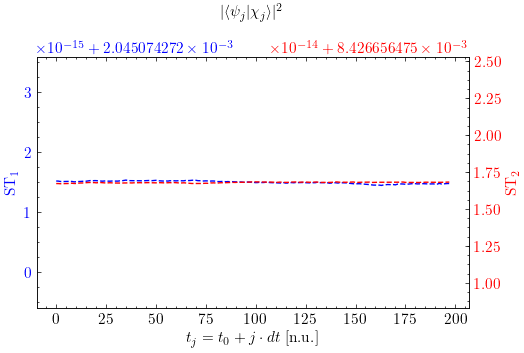

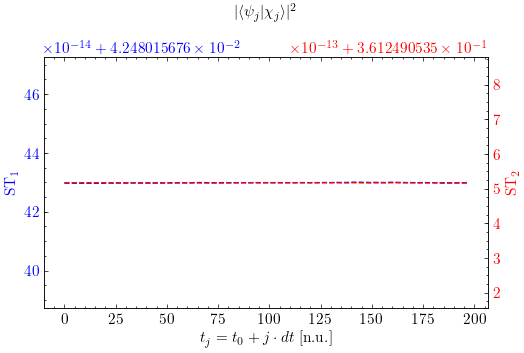

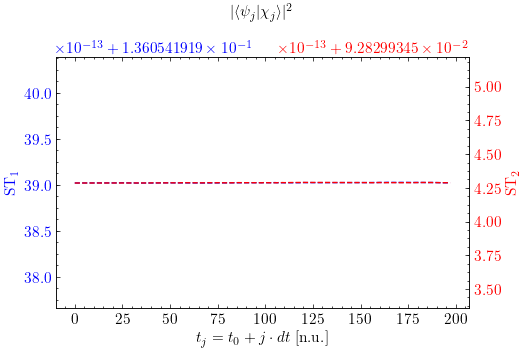

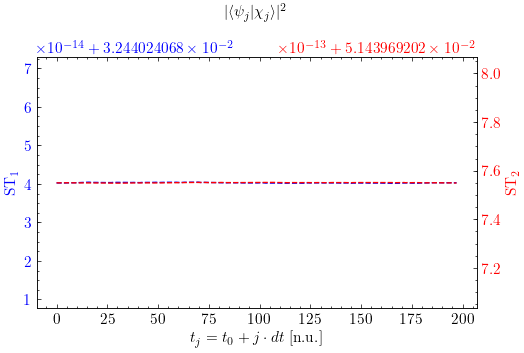

In [23]:
def plot_precision(ct, cr):
    fig, ax1 = plt.subplots(figsize=latex_figsize(wf=1.1))

    color = 'b'
    ax1.set_xlabel('$t_j=t_0+j\cdot dt$ [$\mathrm{n.u.}$]')
    ax1.set_ylabel('$\mathrm{ST}_1$', color=color)
    plt.plot(ct, color=color, linestyle='dashed')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'r'
    ax2.set_ylabel('$\mathrm{ST}_2$', color=color)
    plt.plot(cr, color=color, linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('$|\\langle\psi_j|\chi_j\\rangle|^2$\n')
    plt.show()

for k in range(subdim):
    check_trap = [np.dot(np.conj(trap.evolved_psi[n][k]), trap.evolved_chi[n][k]) for n in range(trap.N)]
    check_trap = [np.real(c * np.conj(c)) for c in check_trap]
    check_rect = [np.dot(np.conj(rect.evolved_psi[n][k]), rect.evolved_chi[n][k]) for n in range(rect.N)]
    check_rect = [np.real(c * np.conj(c)) for c in check_rect]

    plot_precision(check_trap, check_rect)

### Optimal control

In [24]:
# functions for the optimization algorithm
JF_trap = lambda u: 1/2 * (1 - trapezoid(u).F())
gradient_trap = lambda u: trapezoid(u).gradient()

JF_rect = lambda u: 1/2 * (1 - rectangle(u).F())
gradient_rect = lambda u: rectangle(u).gradient()

In [25]:
# initialize control vectors
loc_ctrl = False
np.random.seed(12345)
tcontrol_start = initialize_controls(n_iter=N_trap, loc_ctrl=loc_ctrl)
rcontrol_start = tcontrol_start[:-1]

In [26]:
# callback functions to store the fidelity at each iteration
register_trap, register_rect = [], []

callback_trap = lambda x: register_trap.append(trapezoid(x).F())
callback_rect = lambda x: register_rect.append(rectangle(x).F())

bound = 0.2 * 2 * np.pi / e_unit
bounds_trap = [(-bound, bound) for _ in range(np.prod(tcontrol_start.shape))]
bounds_rect = bounds_trap[:-dim] if loc_ctrl else bounds_trap[:-1]

In [27]:
def printinfo(dict, f):
    if dict['warnflag']==0:
        print(' SIMULATION CONVERGED')
    elif dict['warnflag']==1:
        print(' EXCEEDED NUMBER OF FUNC. EVALUATION')
    else:
        print(' SIMULATION NOT CONVERGED')
    print(' - number of iterations:\t', dict['nit'])
    print(' - final fidelity:\t', 1-2*f)

In [28]:
print('\nTrapezoidal rule') # add pgtol=1e-10?
u_trap, f_trap, d_trap = fmin_l_bfgs_b(func=JF_trap, x0=tcontrol_start, fprime=gradient_trap, bounds=bounds_trap, m=17, factr=10.0, maxfun=900, callback=callback_trap)
printinfo(d_trap, f_trap)


Trapezoidal rule
 SIMULATION CONVERGED
 - number of iterations:	 303
 - final fidelity:	 0.9999744970963241


In [29]:
print('\nRectangular rule')
u_rect, f_rect, d_rect = fmin_l_bfgs_b(func=JF_rect, x0=rcontrol_start, fprime=gradient_rect, bounds=bounds_rect, m=17, factr=10.0, maxfun=900, callback=callback_rect)
printinfo(d_rect, f_rect)


Rectangular rule
 SIMULATION CONVERGED
 - number of iterations:	 260
 - final fidelity:	 0.9998753309561096


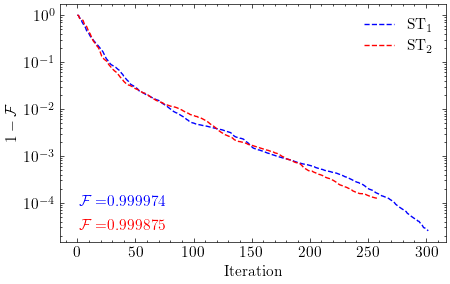

In [30]:
fig, ax = plt.subplots(figsize=latex_figsize())
plt.plot(np.arange(d_trap['nit']), 1 - array(register_trap), color='b', linestyle='dashed', label='$\mathrm{ST}_1$')
plt.plot(np.arange(d_rect['nit']), 1 - array(register_rect), color='r', linestyle='dashed', label='$\mathrm{ST}_2$')

plt.annotate('$\mathcal{F}=$'+str(np.round(1-2*f_trap,6)), color='b', xy=(0.05, 0.15), xycoords='axes fraction')
plt.annotate('$\mathcal{F}=$'+str(np.round(1-2*f_rect,6)), color='r', xy=(0.05, 0.05), xycoords='axes fraction')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$1-\mathcal{F}$')
plt.legend(loc='upper right')
plt.show()

### Visualization

In [31]:
trap = trapezoid(u_trap)
rect = rectangle(u_rect)

print('Trapezoid rule:')
print('F = ', trap.F())
print('\nRectangle rule:')
print('F = ', rect.F())

Trapezoid rule:
F =  0.9999744970963241

Rectangle rule:
F =  0.9998753309561096


In [32]:
check_trap = array([array([np.dot(np.conj(chi), psi) for chi, psi in zip(trap.evolved_chi[-1], trap.evolved_psi[n])]) for n in range(trap.N)])
check_rect = array([array([np.dot(np.conj(chi), psi) for chi, psi in zip(rect.evolved_chi[-1], rect.evolved_psi[n])]) for n in range(rect.N)])

In [33]:
def findket(idx):
    x = str(reps[idx]).replace('(', '$|')
    x = x.replace(')', '\\rangle$')
    return x.replace(',', '')

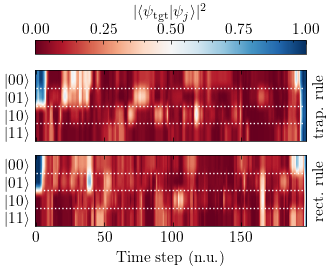

In [34]:
# fidelity colormap
figure, axis = plt.subplots(2, 1, sharex=True)
labels = ['$|00\\rangle$', '$|01\\rangle$', '$|10\\rangle$', '$|11\\rangle$']
ncol = check_trap.shape[1]
yticks = np.array(range(0,trap.subdim))
ylabels = [findket(ii) for ii in range(trap.subdim)]

at = np.abs(check_trap.T)**2
axis[0].imshow(at, cmap='RdBu', aspect='auto')
axis[0].set_yticks(yticks, ylabels)
axis[0].tick_params(left=False, right=False)
axis[0].hlines(0.5, 0, 196, 'white', 'dotted')
axis[0].hlines(1.5, 0, 196, 'white', 'dotted')
axis[0].hlines(2.5, 0, 196, 'white', 'dotted')
axis[0].set_ylabel('trap. rule')
axis[0].yaxis.set_label_position('right')
axis[0].minorticks_off()

ar = np.abs(check_rect.T)**2
img = axis[1].imshow(ar, cmap='RdBu', aspect='auto')
axis[1].set_yticks(yticks, ylabels)
axis[1].tick_params(left=False, right=False)
axis[1].set_xlabel('Time step $(\mathrm{n.u.})$')
axis[1].hlines(0.5, 0, 196, 'white', 'dotted')
axis[1].hlines(1.5, 0, 196, 'white', 'dotted')
axis[1].hlines(2.5, 0, 196, 'white', 'dotted')
axis[1].set_ylabel('rect. rule')
axis[1].yaxis.set_label_position('right')
axis[1].minorticks_off()

cbar = figure.colorbar(img, ax=axis.ravel().tolist(), pad=0.08, location = 'top')
cbar.set_label('$|\langle\psi_{\mathrm{tgt}}|\psi_j\\rangle|^2$')
plt.savefig('plots/cmap.pdf')
plt.show()

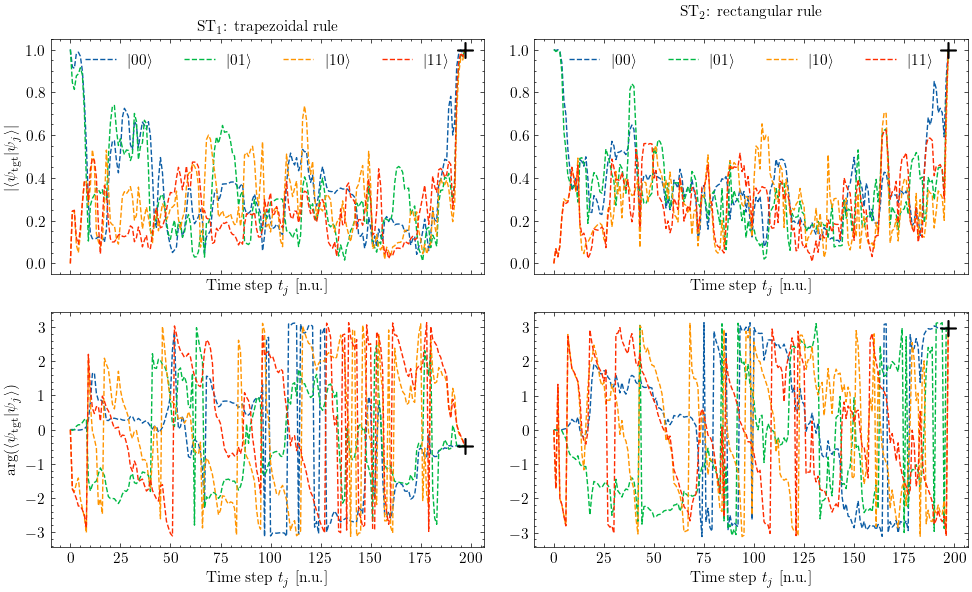

In [35]:
# abs and phase
figure, axis = plt.subplots(2, 2, sharex=True, figsize=latex_figsize(wf=2))
labels = ['$|00\\rangle$', '$|01\\rangle$', '$|10\\rangle$', '$|11\\rangle$']
ncol = check_trap.shape[1]

for y, label in zip(np.abs(check_trap).T, labels):
    axis[0, 0].plot(y, linestyle='dashed', label=label)
last = np.abs(check_trap[-1])**2
axis[0, 0].plot(array([trap.N-1] * len(last)), last, 'k+', markersize=12)
axis[0, 0].set_title('$\mathrm{ST}_1$: trapezoidal rule')
axis[0, 0].set_xlabel('Time step $t_j$ [$\mathrm{n.u.}$]')
axis[0, 0].set_ylabel('$|\langle\psi_{\mathrm{tgt}}|\psi_j\\rangle|$')
axis[0, 0].legend(ncol=ncol)

for y, label in zip(np.abs(check_rect).T, labels):
    axis[0, 1].plot(y, linestyle='dashed', label=label)
last = np.abs(check_rect[-1])**2
axis[0, 1].plot(array([rect.N-1] * len(last)), last, 'k+', markersize=12)
axis[0, 1].set_title('$\mathrm{ST}_2$: rectangular rule\n')
axis[0, 1].set_xlabel('Time step $t_j$ [$\mathrm{n.u.}$]')
axis[0, 1].legend(ncol=ncol)

axis[1, 0].plot(np.angle(check_trap), linestyle='dashed')
last = np.angle(check_trap[-1])
axis[1, 0].plot(array([trap.N-1] * len(last)), last, 'k+', markersize=12)
axis[1, 0].set_xlabel('Time step $t_j$ [$\mathrm{n.u.}$]')
axis[1, 0].set_ylabel('$\\arg(\langle\psi_{\mathrm{tgt}}|\psi_j\\rangle)$')

axis[1, 1].plot(np.angle(check_rect), linestyle='dashed')
last = np.angle(check_rect[-1])
axis[1, 1].plot(array([rect.N-1] * len(last)), last, 'k+', markersize=12)
axis[1, 1].set_xlabel('Time step $t_j$ [$\mathrm{n.u.}$]')

figure.tight_layout()
plt.show()

### Multiple runs

In [36]:
N_runs = 50
runs_trap, runs_rect = [], []

for x in range(N_runs):
    print('\nRunning for run #', x+1)

    register_trap, register_rect = [], []

    tcontrol_start = initialize_controls(n_iter=N_trap, loc_ctrl=loc_ctrl)
    rcontrol_start = tcontrol_start[:-1]

    print('\ntrapezoidal rule')
    u_trap, f_trap, d_trap = fmin_l_bfgs_b(func=JF_trap, x0=tcontrol_start, fprime=gradient_trap, bounds=bounds_trap, m=17, factr=10.0, maxfun=900, callback=callback_trap)
    printinfo(d_trap, f_trap)

    print('\nrectangular rule')
    u_rect, f_rect, d_rect = fmin_l_bfgs_b(func=JF_rect, x0=rcontrol_start, fprime=gradient_rect, bounds=bounds_rect, m=17, factr=10.0, maxfun=900, callback=callback_rect)
    printinfo(d_rect, f_rect)

    runs_trap.append(register_trap)
    runs_rect.append(register_rect)


Running for run # 1

trapezoidal rule
 SIMULATION CONVERGED
 - number of iterations:	 236
 - final fidelity:	 0.999954309512317

rectangular rule
 SIMULATION CONVERGED
 - number of iterations:	 234
 - final fidelity:	 0.9998880421153302

Running for run # 2

trapezoidal rule
 SIMULATION CONVERGED
 - number of iterations:	 217
 - final fidelity:	 0.9998864442903146

rectangular rule
 SIMULATION CONVERGED
 - number of iterations:	 230
 - final fidelity:	 0.9999188323346025

Running for run # 3

trapezoidal rule
 SIMULATION CONVERGED
 - number of iterations:	 244
 - final fidelity:	 0.9999729569748366

rectangular rule
 SIMULATION CONVERGED
 - number of iterations:	 316
 - final fidelity:	 0.9999069255934451

Running for run # 4

trapezoidal rule
 SIMULATION CONVERGED
 - number of iterations:	 209
 - final fidelity:	 0.9999382092718411

rectangular rule
 SIMULATION CONVERGED
 - number of iterations:	 381
 - final fidelity:	 0.9999449089208857

Running for run # 5

trapezoidal rule
 SIMUL

In [37]:
# dummy code to find shortest trajectory and compute the mean
shortest = np.inf
for run in runs_trap:
    x = len(run)
    if x < shortest:
        shortest = x
mean_trap = np.zeros(shortest)
for run in range(N_runs):
    mean_trap += runs_trap[run][0:shortest]

mean_trap /= N_runs


shortest = np.inf
for run in runs_rect:
    x = len(run)
    if x < shortest:
        shortest = x
mean_rect = np.zeros(shortest)
for run in range(N_runs):
    mean_rect += runs_rect[run][0:shortest]

mean_rect /= N_runs

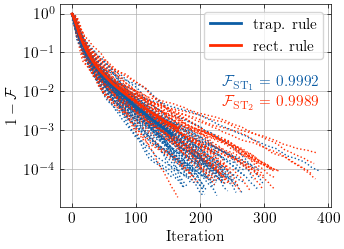

In [38]:
for rt, rr in zip(runs_trap, runs_rect):
    plt.plot(1 - array(rt), color=colorb, linestyle='dotted')
    plt.plot(1 - array(rr), color=colorr, linestyle='dotted')

plt.plot(1 - array(mean_trap), color=colorb, linewidth=2, label='trap. rule')
plt.plot(1 - array(mean_rect), color=colorr, linewidth=2, label='rect. rule')
linestyle='dashed', 
plt.annotate('$\mathcal{F}_{\mathrm{ST}_1}=$ '+str(np.round(mean_trap[-1],4)), color=colorb, xy=(0.6, 0.6), xycoords='axes fraction')
plt.annotate('$\mathcal{F}_{\mathrm{ST}_2}=$ '+str(np.round(mean_rect[-1],4)), color=colorr, xy=(0.6, 0.5), xycoords='axes fraction')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$1-\mathcal{F}$')
plt.legend(loc='upper right', frameon=True)
plt.minorticks_off()
plt.grid(True)
plt.savefig('plots/gate_transfer.pdf')
plt.show()